In [1]:
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
# mdmm constraint impl
import mdmm
import pdb

In [2]:
# %matplotlib notebook
# from IPython.display import HTML
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation

# # Parameters
# nx = 100  # number of spatial steps
# dx = 2 * np.pi / nx  # space step
# nt = 100  # number of time steps
# dt = 0.01  # time step
# nu = 0.07  # viscosity

# # Initialize the grid and initial condition
# x = np.linspace(0, 2 * np.pi, nx, endpoint=False)
# u = np.array([np.sin(xi) for xi in x])  # initial condition

# # Function to compute the next time step
# def step(u, dx, dt, nu):
#     un = u.copy()
#     for i in range(1, len(u)-1):
#         u[i] = (un[i] - un[i] * dt / dx * (un[i] - un[i-1]) + 
#                 nu * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1]))
#     # Periodic boundary conditions
#     u[0] = (un[0] - un[0] * dt / dx * (un[0] - un[-2]) + 
#             nu * dt / dx**2 * (un[1] - 2 * un[0] + un[-2]))
#     u[-1] = u[0]
#     return u

# # Prepare the plot
# fig, ax = plt.subplots()
# line, = ax.plot(x, u, color='b')
# ax.set_xlim([0, 2 * np.pi])
# ax.set_ylim([-1, 1])
# ax.set_title("1D Burgers' Equation")
# ax.set_xlabel('x')
# ax.set_ylabel('u')

# # Update function for the animation
# def update(frame):
#     global u
#     u = step(u, dx, dt, nu)
#     line.set_ydata(u)
#     return line,

# # Create the animation
# ani = FuncAnimation(fig, update, frames=nt, blit=True)

# # Display the animation
# HTML(ani.to_jshtml())


In [3]:
def split_final(dat, t1,t2):
    # To test the final state
    final_x = np.array(dat[:, -t1-t2:-t2]).reshape((1, dat.shape[0], t1))
    final_y = np.array(dat[:, -t2:]).reshape((1, dat.shape[0], t2))
    dat = dat[:, :-t1-t2]
    return final_x, final_y, dat

def data_split(dat, train_hour, test_hour,stride):
    X, Y = [], []
    period = train_hour + test_hour
    i = 0
    while i + period < dat.shape[1]:
        X.append(dat[:, i:i + train_hour])
        Y.append(dat[:, i+train_hour:i+period])
        i += stride
    return np.array(X), np.array(Y)

def flatten(y):
    return np.swapaxes(y, 0, 1).reshape(y.shape[1], y.shape[0]*y.shape[2])


In [4]:
# plotting
def multi_heatmap(Test_y, Pred_y, plot_name):
    sns.set(font_scale = 2)
    py = flatten(Pred_y)
    ty = flatten(Test_y)
    #Plot the new heatmap of predict data vs test data
    plt.figure()
    print(len(py),len(ty))
    ax1 = sns.heatmap(np.array(ty).T,vmin = 0, vmax = 1)
    ax1.set_title('Exact Data')
    ax1.set(xlabel='X (grid point)', ylabel='Time Step')
    ax1.tick_params(labelsize=15)
    f1 = ax1.get_figure()
    f1.savefig(output + str(plot_name) + '_Exact_heatmap.png', bbox_inches='tight')
    #plt.show()
    plt.figure()
    ax2 = sns.heatmap(np.array(py).T,vmin = 0, vmax = 1)
    ax2.set_title('Predicted Data')
    ax2.set(xlabel='X (grid point)', ylabel='Time Step')
    ax2.tick_params(labelsize=15)
    f2 = ax2.get_figure()
    f2.savefig(output + str(plot_name) + '_Predicted_heatmap.png',bbox_inches='tight')
    #plt.show()
    return 


In [5]:
class StackedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(StackedLSTM, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, 
                             batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=hidden_dim*2, hidden_size=hidden_dim, 
                             batch_first=True, bidirectional=True)

        self.attention = nn.MultiheadAttention(embed_dim=hidden_dim*2, num_heads=1)
        
        # Dense layer
        self.dense = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        # Passing the input through the first LSTM layer
        x, _ = self.lstm1(x)

        # Passing the output through the second LSTM layer
        x, _ = self.lstm2(x)

        # Applying self-attention
        attn_output, _ = self.attention(x, x, x)
        # attn_output = attn_output.transpose(0, 1)

        # Passing the output through the dense layer
        output = self.dense(attn_output)
        
        return output



In [6]:
def u(x,t):
    return [0.5*(np.sin(4*np.pi*xi+t) + np.sin(4*np.pi*xi-t)) for xi in x]
def wave(dx, dt, nx, nt, plot = 0):
    T = dt*nt
    x0 = np.linspace(0,nx*dx,nx+1)
    t = np.linspace(0,nt*dt,nt+1)
    wave_dat = np.array(u(x0,t))
    print('wave data shape: ', wave_dat.shape) # (nx+1, nt+1)
    if plot:
        fig = plt.figure()
        ax1 = fig.add_subplot(211)
        ax1.plot(x0,u(x0,0))
        ax1.tick_params(labelsize= 15)
        ax1.set_title('Initial Condition')
        fig2 = plt.figure()
        ax2 = fig2.add_subplot(212)
        ax2.plot(x0,u(x0,T))
        ax2.set_title('Final State t=: '+str(T))
        ax2.tick_params(labelsize= 15)
        plt.ylim(-1,1)
        plt.show()
    return wave_dat

def burger(dx, dt, nx, nt, plot=0):
    nu = 0.07  # viscosity

    # Initialize the grid
    x = np.linspace(0, 2 * np.pi, nx, endpoint=False)

    # Create the initial condition
    u_initial = np.sin(x)

    # # Create the boundary condition
    u_boundary = u_initial[0]


    # Store the data of each timestep's u values
    u_data = []

    # Function to compute the next time step
    def step(u, dx, dt, nu):
        un = u.copy()
        for i in range(1, len(u)-1):
            u[i] = (un[i] - un[i] * dt / dx * (un[i] - un[i-1]) + 
                    nu * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1]))
        # Periodic boundary conditions
        u[0] = (un[0] - un[0] * dt / dx * (un[0] - un[-2]) + 
                nu * dt / dx**2 * (un[1] - 2 * un[0] + un[-2]))
        u[-1] = u[0]
        return u

    # Compute and store the data of each timestep's u values
    u = u_initial.copy()
    u_data.append(u.copy())  # Store the initial condition
    for timestep in range(nt):
        u = step(u, dx, dt, nu)
        u_data.append(u.copy())
        # plot u every 10 timesteps
        if timestep % 100 == 0 and plot:
            plt.plot(x, u.copy())
    if plot:
        plt.figure()
        plt.plot(x, u_initial, label='Initial Condition')
        plt.plot(x, u, label='Final State t = {}'.format(nt*dt))
        plt.title('Burger\'s Equation')
        plt.xlabel('x')
        plt.ylabel('u')
        plt.legend()
        plt.show()

    return u_data


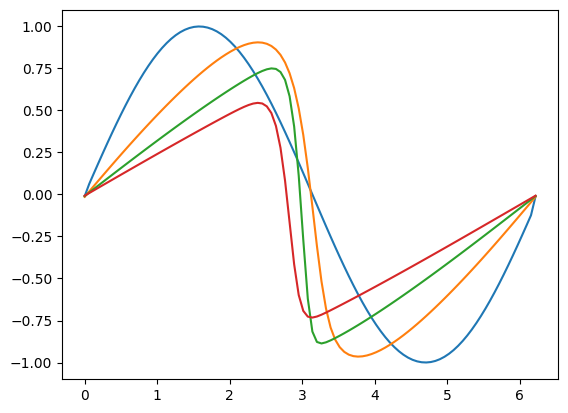

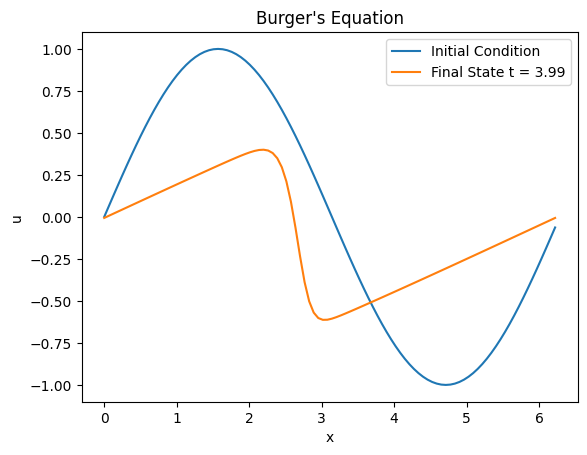

wave final x shape:  (1, 100, 90)
wave final y shape:  (1, 100, 30)
wave data shape:  (100, 280)


Text(0.5, 1.0, 'Values of u at the left boundary over time')

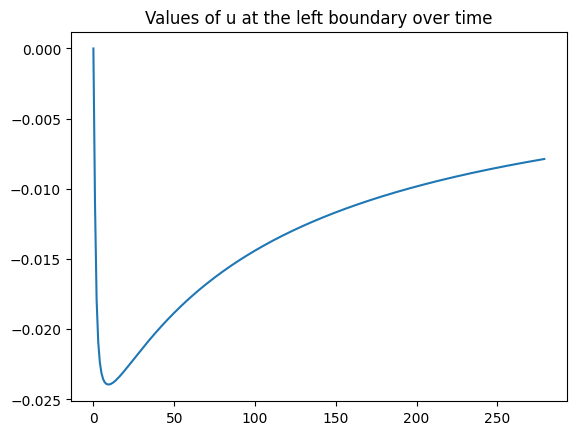

In [17]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
# T = 6.0
# X = 1.0
# dt = 0.01
# dx = 0.01
# #seq2seq train
# t1, t2 = 90, 30
# N = 20
# nx = int(X / dx)
# nt = int(T / dt)
# wave_dat = wave(dx,dt,nx, nt, 0)

# Parameters for burger's equation
t1, t2 = 90, 30
nx = 100  # number of spatial steps
dx = 2 * np.pi / nx  # space step
nt = 399  # number of time steps
dt = 0.01  # time step
nu = 0.07  # viscosity
burger_dat = burger(dx, dt, nx, nt, 1)
burger_dat = np.array(burger_dat).T
burger_final_x, burger_final_y, burger_dat = split_final(burger_dat, t1, t2)
print('wave final x shape: ', burger_final_x.shape)
print('wave final y shape: ', burger_final_y.shape)
print('wave data shape: ', burger_dat.shape)


# # plot the first four time steps
# fig, ax = plt.subplots()
# ax.plot(burger_dat[0, :], color='b')
# ax.plot(burger_dat[1, :], color='r')

import matplotlib.animation as animation
# Prepare the plot
# fig, ax = plt.subplots()
# line, = ax.plot(burger_dat[:,0], color='b')
# ax.set_title("Burgers' Equation")
# ax.set_xlabel('x')
# ax.set_ylabel('u')

# # Update function for the animation
# def update(frame):
#     line.set_ydata(burger_dat[:,frame])
#     return line,

# # Create the animation
# ani = FuncAnimation(fig, update, frames= 15, blit=True)

# # Display the animation
# HTML(ani.to_jshtml())


# plot the values of u at the left boundary over time
plt.plot(burger_dat[0, :])
plt.title('Values of u at the left boundary over time')

In [ ]:
t = np.linspace(0, nt*dt, nt+1)

In [45]:
# learning
test_portion = 0.2
data_x, data_y = data_split(burger_dat, t1, t2, 1)
print('data x shape: ', data_x.shape)
print('data y shape: ', data_y.shape)
# train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=test_portion)
# the first 80% of the data will be used for training and the last 20% for testing
train_x, test_x, train_y, test_y = data_x[:int(data_x.shape[0]*(1-test_portion))], data_x[int(data_x.shape[0]*(1-test_portion)):], \
                                    data_y[:int(data_y.shape[0]*(1-test_portion))], data_y[int(data_y.shape[0]*(1-test_portion)):]

print('train x shape: ', train_x.shape)
print('train y shape: ', train_y.shape)
print('test x shape: ', test_x.shape)
print('test y shape: ', test_y.shape)
# Convert the data to PyTorch tensors
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).float()
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).float()
gpu_id = 0
device = torch.device(f'cuda:{gpu_id}' if torch.cuda.is_available() else 'cpu')



data x shape:  (160, 100, 90)
data y shape:  (160, 100, 30)
train x shape:  (128, 100, 90)
train y shape:  (128, 100, 30)
test x shape:  (32, 100, 90)
test y shape:  (32, 100, 30)


In [9]:
# train the stackedLSTM
input_dim = data_x.shape[2]
output_dim = data_y.shape[2]


# Create the model
model = StackedLSTM(input_dim, 20, output_dim)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.to(device)
train_x, train_y = train_x.to(device), train_y.to(device)
test_x, test_y = test_x.to(device), test_y.to(device)



# Train the model
epochs = 100
batch_size = 2
for epoch in range(epochs):
    for i in range(0, len(train_x), batch_size):
        # Get the batch
        batch_x = train_x[i:i+batch_size]
        batch_y = train_y[i:i+batch_size]
         
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(batch_x)
        

        # Calculate the loss
        loss = criterion(output, batch_y)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 1/100, Loss: 0.0612


KeyboardInterrupt: 

In [ ]:
# predict step
model.eval()

# Predict the test set
with torch.no_grad():
    test_pred = model(test_x)
    test_loss = criterion(test_pred, test_y)
    print(f'Test Loss: {test_loss.item():.4f}')

# shapes
print('test pred shape: ', test_pred.shape)
print('test y shape: ', test_y.shape)

# Prepare the plot
fig, ax = plt.subplots()
line, = ax.plot(np.linspace(0,nx*dx,nx+1), test_pred[0,:, 0].cpu().numpy(), color='b')
line2, = ax.plot(np.linspace(0,nx*dx,nx+1), test_y[0,:, 0].cpu().numpy(), color='r')
ax.set_xlim([0, 1.0])
ax.set_ylim([-1, 1])
ax.set_title("Wave Equation")
ax.set_xlabel('x')
ax.set_ylabel('u')

# Update function for the animation
def update(frame):
    line.set_ydata(test_pred[frame,:,0].cpu().numpy())
    line2.set_ydata(test_y[frame,:,0].cpu().numpy())
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames= 20, blit=True)

# Display the animation
HTML(ani.to_jshtml())



Now, let us say that we can only see the data between 0.3 and 0.6 in the spatial domain across all time steps. We also know the initial and boundary conditions, which are:
u(x,0) = sin(4*pi*x)
u(0,t) = u(1,t)
We need to model the initial condition as a value constraint. 


Now, we are going to attach constraints and remove some training data.

In [51]:
# LSTM with partial information on the training data. We are also given the initial and 
# boundary condition.

initial_condition = burger_dat[:,0]
initial_condition = torch.tensor(initial_condition).to(device)

# now, we create partial training data
start_index = 0.40
end_index = 0.60
train_x_partial = train_x
train_x_partial = train_x_partial[:, int(start_index*train_x_partial.shape[1]):int(end_index*train_x_partial.shape[1]), :]

# # boundary conditions on the left and right
left_boundary_x = train_x[:, 0, :]
# right_boundary_x = train_x[:, -1, :]
left_boundary_x = left_boundary_x.to(device)
# right_boundary_x = right_boundary_x.to(device)

# left_boundary_y = train_y[:, 0, :]
# right_boundary_y = train_y[:, -1, :]
# left_boundary_y = (left_boundary_y).to(device)
# right_boundary_y = (right_boundary_y).to(device)


train_y_partial = train_y
train_y_partial = train_y_partial[:, int(start_index*train_y_partial.shape[1]):int(end_index*train_y_partial.shape[1]), :]


In [52]:
# train the stackedLSTM
input_dim = data_x.shape[2]
output_dim = data_y.shape[2]

# Create the model
model_constrained = StackedLSTM(input_dim, 20, output_dim)

idx_left_boundary = 0
idx_right_boundary = 0

def left_boundary_constraint(*args, **kwargs):
    return model_constrained(args[1]).ravel()

# def right_boundary_constraint(*args, **kwargs):
#     return model_constrained(args[2]).ravel()

# Train the model
epochs = 100
batch_size = 2

left_boundary_y = torch.zeros(2, 1, 30).ravel().to(device)
right_boundary_y = torch.zeros(2, 1, 30).ravel().to(device)

left_boundary_fn = mdmm.EqConstraint(left_boundary_constraint, left_boundary_y)
# right_boundary_fn = mdmm.EqConstraint(right_boundary_constraint, right_boundary_y)
mdmm_module = mdmm.MDMM([left_boundary_fn])
optimizer = mdmm_module.make_optimizer(model_constrained.parameters(), lr = 1e-4)


# Define the loss function and the optimizer
criterion = nn.MSELoss()

gpu_id = 0
device = torch.device(f'cuda:{gpu_id}' if torch.cuda.is_available() else 'cpu')
model_constrained.to(device)
train_x_partial, train_y_partial = train_x_partial.to(device), train_y_partial.to(device)
test_x, test_y = test_x.to(device), test_y.to(device)

for epoch in range(epochs):
    for i in range(0, len(train_x), batch_size):
        # Get the batch
        batch_x = train_x_partial[i:i+batch_size].to(device)
        batch_y = train_y_partial[i:i+batch_size].to(device)
        left_bdry = left_boundary_x[i:i+batch_size].unsqueeze(1).to(device)
        # right_bdry = right_boundary_x[i:i+batch_size].unsqueeze(1).to(device)
        
         
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model_constrained(batch_x)

        # Calculate the loss
        loss_data = criterion(output, batch_y)
        # pass the loss_data, right_boundary and left_boundary to the mdmm_module
        mdmm_return = mdmm_module(loss_data, left_bdry)

        # Backward pass
        mdmm_return.value.backward()

        # Update the weights
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Total Loss: {mdmm_return.value:.4f} Data Loss: {loss_data.item():.4f} \
          Left Boundary Loss: {mdmm_return.infs[0].mean():.4f}')

Epoch 1/100, Total Loss: 0.4340 Data Loss: 0.4303           Left Boundary Loss: -0.0150
Epoch 2/100, Total Loss: 0.3125 Data Loss: 0.3094           Left Boundary Loss: -0.0042
Epoch 3/100, Total Loss: 0.1412 Data Loss: 0.1385           Left Boundary Loss: 0.0106
Epoch 4/100, Total Loss: 0.0563 Data Loss: 0.0539           Left Boundary Loss: 0.0153
Epoch 5/100, Total Loss: 0.0301 Data Loss: 0.0279           Left Boundary Loss: 0.0105
Epoch 6/100, Total Loss: 0.0203 Data Loss: 0.0184           Left Boundary Loss: 0.0069
Epoch 7/100, Total Loss: 0.0166 Data Loss: 0.0149           Left Boundary Loss: 0.0036
Epoch 8/100, Total Loss: 0.0144 Data Loss: 0.0129           Left Boundary Loss: 0.0006
Epoch 9/100, Total Loss: 0.0125 Data Loss: 0.0112           Left Boundary Loss: -0.0021
Epoch 10/100, Total Loss: 0.0110 Data Loss: 0.0098           Left Boundary Loss: -0.0042
Epoch 11/100, Total Loss: 0.0096 Data Loss: 0.0086           Left Boundary Loss: -0.0057
Epoch 12/100, Total Loss: 0.0084 Dat

In [53]:
# now train a model with no boundary conditions constraint
model_no_constraint = StackedLSTM(input_dim, 20, output_dim)
model_no_constraint.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_no_constraint.parameters(), lr=1e-4)
train_x, train_y = train_x.to(device), train_y.to(device)
test_x, test_y = test_x.to(device), test_y.to(device)

# Train the model
epochs = 100
batch_size = 2
for epoch in range(epochs):
    for i in range(0, len(train_x), batch_size):
        # Get the batch
        batch_x = train_x_partial[i:i+batch_size]
        batch_y = train_y_partial[i:i+batch_size]
         
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model_no_constraint(batch_x)
        

        # Calculate the loss
        loss = criterion(output, batch_y)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 1/100, Loss: 0.3951
Epoch 2/100, Loss: 0.1643
Epoch 3/100, Loss: 0.0455
Epoch 4/100, Loss: 0.0157
Epoch 5/100, Loss: 0.0098
Epoch 6/100, Loss: 0.0074
Epoch 7/100, Loss: 0.0056
Epoch 8/100, Loss: 0.0043
Epoch 9/100, Loss: 0.0036
Epoch 10/100, Loss: 0.0031
Epoch 11/100, Loss: 0.0027
Epoch 12/100, Loss: 0.0023
Epoch 13/100, Loss: 0.0021
Epoch 14/100, Loss: 0.0018
Epoch 15/100, Loss: 0.0016
Epoch 16/100, Loss: 0.0014
Epoch 17/100, Loss: 0.0013
Epoch 18/100, Loss: 0.0012
Epoch 19/100, Loss: 0.0011
Epoch 20/100, Loss: 0.0011
Epoch 21/100, Loss: 0.0010
Epoch 22/100, Loss: 0.0009
Epoch 23/100, Loss: 0.0009
Epoch 24/100, Loss: 0.0008
Epoch 25/100, Loss: 0.0008
Epoch 26/100, Loss: 0.0007
Epoch 27/100, Loss: 0.0007
Epoch 28/100, Loss: 0.0006
Epoch 29/100, Loss: 0.0006
Epoch 30/100, Loss: 0.0006
Epoch 31/100, Loss: 0.0005
Epoch 32/100, Loss: 0.0005
Epoch 33/100, Loss: 0.0005
Epoch 34/100, Loss: 0.0005
Epoch 35/100, Loss: 0.0004
Epoch 36/100, Loss: 0.0004
Epoch 37/100, Loss: 0.0004
Epoch 38/1

Test Loss: 0.0323 UnConstrained Test Loss: 0.0689
test pred shape:  torch.Size([32, 100, 30])
test y shape:  torch.Size([32, 100, 30])


MovieWriter imagemagick unavailable; using Pillow instead.


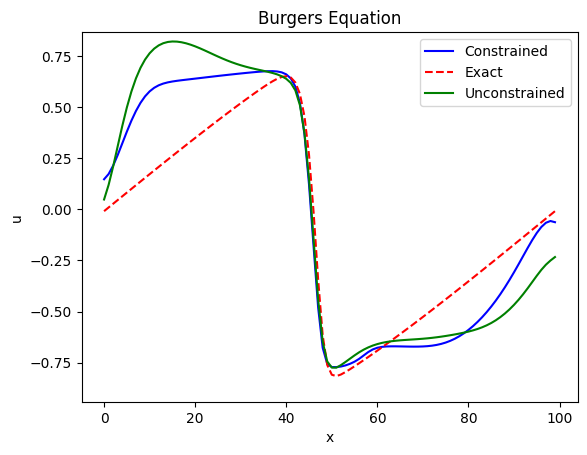

In [55]:
# predict step
model_constrained.eval()
model_no_constraint.eval()
# Predict the test set
with torch.no_grad():
    test_pred = model_constrained(test_x)
    test_pred_unconstrained = model_no_constraint(test_x)
    test_loss = criterion(test_pred, test_y)
    test_loss_unconstrained = criterion(test_pred_unconstrained, test_y)
    print(f'Test Loss: {test_loss.item():.4f} UnConstrained Test Loss: {test_loss_unconstrained.item():.4f}')

# shapes
print('test pred shape: ', test_pred.shape)
print('test y shape: ', test_y.shape)

# Prepare the plot
fig, ax = plt.subplots()
line, = ax.plot(test_pred[0,:, 0].cpu().numpy(), color='b')
line2, = ax.plot(test_y[0,:, 0].cpu().numpy(), color='r', linestyle='--')
line3, = ax.plot(test_pred_unconstrained[0,:, 0].cpu().numpy(), color='g')
ax.set_title("Burgers Equation")
ax.set_xlabel('x')
ax.set_ylabel('u')
# legend 
ax.legend(['Constrained', 'Exact', 'Unconstrained'])
# Update function for the animation
def update(frame):
    line.set_ydata(test_pred[0,:,frame].cpu().numpy())
    line2.set_ydata(test_y[0,:,frame].cpu().numpy())
    line3.set_ydata(test_pred_unconstrained[0,:,frame].cpu().numpy())
    return line, line2, line3

# Create the animation
ani = FuncAnimation(fig, update, frames= 29, blit=True)

# Display the animation
HTML(ani.to_jshtml())

# save animation as gif
ani.save('burger_equation_constrained_040060.gif', writer='imagemagick', fps=5)
